In [1]:
import pandas as pd
import numpy as np
import preprocessing as pp
import train_test_sets
import modelling
from tqdm import tqdm
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, f1_score, plot_confusion_matrix
import pickle5 as pickle

In [2]:
mri_subs_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_Data_Voxels_894.parquet" 
mri_areas_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_Data_Areas_890.csv" 
bb_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/BigBrain.xlsx"
ids_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/participants_nkienhanced.tsv"

In [3]:
# freesufer data
mri_subs_all = pp.read_parquet(mri_subs_path)

# sample, drop zeros and encode cats
mri_subs = pp.clean_sample(mri_subs_all, sample_size=50)

# quality assessment
bad_participants = pp.find_bad_ones(mri_areas_path)
mri_subs = pp.eliminate_bad_ones(bad_participants, mri_subs)
mri_subs.head()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,participant,hemisphere,atlasEcono,atlasDF,area,curv,sulc,thickness,age,sex,handedness
2401996,A00027167,left,27,11,0.061126,-0.354878,-5.671288,1.612637,14.0,FEMALE,RIGHT
2401997,A00027167,left,27,11,0.134875,-0.369926,-5.725038,1.739316,14.0,FEMALE,RIGHT
2401998,A00027167,left,27,11,0.216723,-0.369103,-5.672037,1.942646,14.0,FEMALE,RIGHT
2401999,A00027167,left,27,11,0.127283,-0.350193,-5.968047,1.678501,14.0,FEMALE,RIGHT
2402000,A00027167,left,27,11,0.353651,-0.361715,-5.944244,1.856771,14.0,FEMALE,RIGHT


In [4]:
# add identification features
#mri_subs = pp.ids_features(ids_path, mri_subs)
mri_subs1 = pp.cat2int(mri_subs, cat_features=['sex', 'handedness', 'hemisphere'])
mri_subs1.head()

,participant,hemisphere,atlasEcono,atlasDF,area,curv,sulc,thickness,age,sex,handedness
2401996,A00027167,0,27,11,0.061126,-0.354878,-5.671288,1.612637,14.0,0,2
2401997,A00027167,0,27,11,0.134875,-0.369926,-5.725038,1.739316,14.0,0,2
2401998,A00027167,0,27,11,0.216723,-0.369103,-5.672037,1.942646,14.0,0,2
2401999,A00027167,0,27,11,0.127283,-0.350193,-5.968047,1.678501,14.0,0,2
2402000,A00027167,0,27,11,0.353651,-0.361715,-5.944244,1.856771,14.0,0,2


In [3]:
# add bigbrain features
mri_subs = pp.bb_features(bb_path, mri_subs)

# prepare sets to models train and test
Xy_sets = train_test_sets.separate(mri_subs) 

# retorna 4 elementos, 2 conjuntos de treino e teste, um a nivel de vertice e outro a nivel de estrutura cortical
Xy_train_vo, Xy_test_vo, Xy_train_gr, Xy_test_gr = Xy_sets

# lista de variaveis que temos nas bases
#Xy_train_vo.columns#, Xy_train_gr.columns

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Index(['participant', 'hemisphere', 'atlasEcono', 'atlasDF', 'area', 'curv',
       'sulc', 'thickness', 'age', 'sex', 'handedness', 'structure', 've_1',
       've_2', 've_3', 've_4', 've_5', 've_6', 'bigbrain_layer_1',
       'bigbrain_layer_2', 'bigbrain_layer_3', 'bigbrain_layer_4',
       'bigbrain_layer_5', 'bigbrain_layer_6', 'bigbrain_layer_1_r',
       'bigbrain_layer_2_r', 'bigbrain_layer_3_r', 'bigbrain_layer_4_r',
       'bigbrain_layer_5_r', 'bigbrain_layer_6_r', 'bblayer1_age',
       'bblayer2_age', 'bblayer3_age', 'bblayer4_age', 'bblayer5_age',
       'bblayer6_age', 've1_age', 've2_age', 've3_age', 've4_age', 've5_age',
       've6_age', 'h_structure'],
      dtype='object')

In [4]:
# experiment 1
m = modelling.Model(Xy_sets,
                     path_images_outputs = '/home/brunovieira/Tamires_Experiments/Outputs/exp0/',
                     features = ['sex', 'handedness', 'hemisphere',
                                 'age','area', 'sulc', 'curv',
                                 'bigbrain_layer_1', 'bigbrain_layer_2','bigbrain_layer_3', 
                                 'bigbrain_layer_4', 'bigbrain_layer_5','bigbrain_layer_6'
                                 ], 
                     hyperparameter_search_size = 2,
                     voxel = False,
                     structure_modeling = False,
                     structure_evaluation = False #so faz sentido para voxel=True
                    )

In [5]:
#m.test('vizualization')

In [6]:
#m.explicability()

In [7]:
m.set_resume()

{'Target ': 'thickness',
 'Features': 'sex, handedness, hemisphere, age, area, sulc, curv, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6',
 'Algoritmo': 'LGBMClassifier',
 'Hyperparameters': {'learning_rate': 0.005,
  'max_depth': 10,
  'min_child_samples': 10,
  'n_estimators': 700,
  'num_leaves': 50,
  'reg_alpha': 0,
  'reg_lambda': 0,
  'subsample_for_bin': 20000},
 'Base de Dados instancias': 3720,
 'Base de Dados participantes': 48.94736842105263,
 'Model Type': 'Estruturas Corticais',
 'structure_modeling': False,
 'structure_evaluation': False}

100%|██████████| 3/3 [00:06<00:00,  2.32s/it]


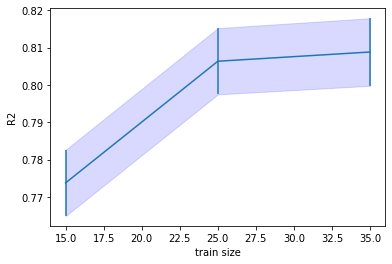

<Figure size 432x288 with 0 Axes>

In [8]:
m.learning_curv(list_sizes = [15,25,35])

Rascunho

In [9]:
1: 0.5, -2.28
2: 0.53, -2.25
3: 0.51, -2.46
4: 0.61, -1.58
5: 0.71, -0.66
6: 0.58, -2.07
atlasEconomo: 0.8, 0.02

SyntaxError: illegal target for annotation (1366074441.py, line 1)